# Tutorial for Spatial Neighborhood Analysis (SNA) & Spatial Co-localization Score (sCLS) Using Simulation Data

**Author:**  
**Jun Inamo**  
_Computational Omics and Systems Immunology (COSI) Lab_  
_Division of Rheumatology and Center for Health AI_  
_University of Colorado School of Medicine, CO, USA_  
📧 jun.inamo@cuanschutz.edu


In [1]:

format(Sys.time(), '%d %B, %Y')

[1] "04 April, 2025"

# Spatial neighborhood analysis (SNA, cell type level analysis)

First generate dummy data where two cell types (cell_type_1 and cell_type_2 in "cell_type" cik) are close to each other. Here we assume that cell_type_1 and cell_type_2 are close to each other (concentric cicle) by close_ratio.
Make sure to assume >10 cell types to see the effect of neighborhood enrichment analysis. If this total cell types are less than 10, the analysis may by susceptible to false positive results because cell labels are shuffling in permutation test.


In [2]:
library(spatialCooccur)
library(patchwork)
library(ggplot2)
library(magrittr)
library(dplyr)
library(circlize)
library(ComplexHeatmap)
library(ggrastr)

Warning message:
"replacing previous import 'dplyr::combine' by 'gridExtra::combine' when loading 'spatialCooccur'"
Warning message:
"replacing previous import 'dplyr::as_data_frame' by 'igraph::as_data_frame' when loading 'spatialCooccur'"
Warning message:
"replacing previous import 'Seurat::components' by 'igraph::components' when loading 'spatialCooccur'"
Warning message:
"replacing previous import 'dplyr::groups' by 'igraph::groups' when loading 'spatialCooccur'"
Warning message:
"replacing previous import 'dplyr::union' by 'igraph::union' when loading 'spatialCooccur'"
Warning message:
"replacing previous import 'circlize::degree' by 'igraph::degree' when loading 'spatialCooccur'"
Warning message:
"replacing previous import 'ComplexHeatmap::pheatmap' by 'pheatmap::pheatmap' when loading 'spatialCooccur'"
Warning message:
"replacing previous import 'igraph::as_data_frame' by 'tibble::as_data_frame' when loading 'spatialCooccur'"

Attaching package: 'dplyr'


The following objects a

In [3]:

seed=1234
close_ratio=1  # proportion of cell_type_1 and cell_type_2 that are close to each other
n_types=15  # Number of cell types
max_loc=800 # Maximum x and y coordinates in space
n_cells=500  # Number of total cells
test_type="circle" # "line", "circle", "distribute"
distance_param=20  # distance between cell_type_1 and cell_type_2

df = generate_sim(close_ratio = close_ratio, 
                  n_types = n_types,  
                  max_loc = max_loc,
                  n_cells = n_cells,  
                  test_type = test_type,
                  distance_param = distance_param,  
                  seed=seed)
head(df) 
# x and y: coordinates
# cell_type: cell type

,x,y,cell_type
,<dbl>,<dbl>,<fct>
1,355.4030,392.7360,cell_type_1
2,490.8708,345.9954,cell_type_1
3,451.1619,308.7717,cell_type_1
4,501.4539,430.0083,cell_type_1
5,280.3691,433.8681,cell_type_1
6,389.7839,506.7382,cell_type_1


check the distribution of cell types in the space

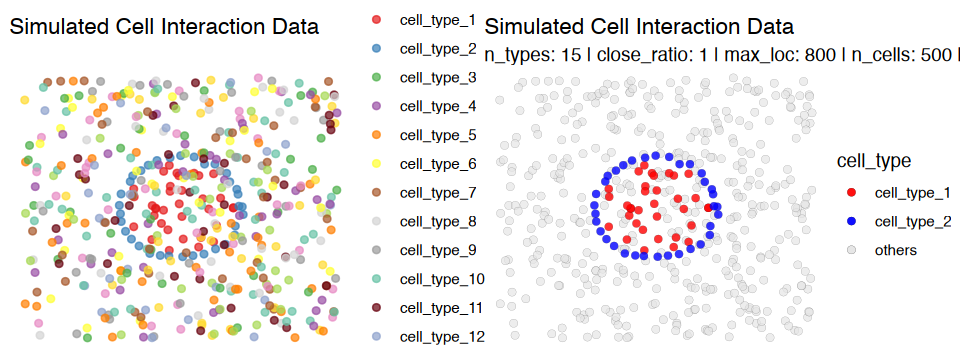

In [4]:

cluster_colors = manual_colors
names(cluster_colors) = paste0("cell_type_",1:n_types)

g1 = ggplot(df, aes(x = x, y = y, color = cell_type)) +
  geom_point(alpha = 0.7) +
  scale_color_manual(values = cluster_colors) +
  theme_void() +
  ggtitle("Simulated Cell Interaction Data")

g2 = ggplot(df %>% dplyr::mutate(cell_type = ifelse(cell_type %in% c("cell_type_1","cell_type_2"),as.character(cell_type),"others")), aes(x = x, y = y, fill = cell_type)) +
  geom_point(data = df %>% dplyr::mutate(cell_type = ifelse(cell_type %in% c("cell_type_1","cell_type_2"),as.character(cell_type),"others")) %>% dplyr::filter(cell_type %in% c("others")),
             alpha = 0.7, size = 2, shape = 21, stroke = 0.05, color = "black") +
  geom_point(data = df %>% dplyr::mutate(cell_type = ifelse(cell_type %in% c("cell_type_1","cell_type_2"),as.character(cell_type),"others")) %>% dplyr::filter(cell_type %in% c("cell_type_1","cell_type_2")),
             alpha = 0.8, size = 2, shape = 21, stroke = 0.05, color = "black") +
  labs(title = "Simulated Cell Interaction Data",
       subtitle = paste("n_types:", n_types, "| close_ratio:", close_ratio, "| max_loc:", max_loc, "| n_cells:", n_cells, "| distance_param:",distance_param)) +
  scale_color_manual(values = c("cell_type_1" = "red", 
                                "cell_type_2" = "blue",
                                "others" = "grey90")) +
  scale_fill_manual(values = c("cell_type_1" = "red", 
                               "cell_type_2" = "blue",
                               "others" = "grey90")) +
  theme_void()

  options(repr.plot.width=8, repr.plot.height=3)
g1|g2

Run neighborhood enrichment analysis

In [5]:
n_perm = 100
neighbors.k_ = 30 # Number of neighbors to search

nhood_enrichment_res <- nhood_enrichment(
  df,
  cluster_key = "cell_type", 
  neighbors.k = neighbors.k_, 
  connectivity_key = "nn", 
  transformation = TRUE,
  n_perms = n_perm, seed = seed, n_jobs = 4
)
nhood_enrichment_res=nhood_enrichment_res$zscore

nhood_enrichment_res

,Clustercell_type_1,Clustercell_type_2,Clustercell_type_3,Clustercell_type_4,Clustercell_type_5,Clustercell_type_6,Clustercell_type_7,Clustercell_type_8,Clustercell_type_9,Clustercell_type_10,Clustercell_type_11,Clustercell_type_12,Clustercell_type_13,Clustercell_type_14,Clustercell_type_15
Clustercell_type_1,17.8726375,4.7514478,-3.62967042,-2.1135809,-3.17201567,-2.27912897,-3.49281136,-2.76728430,-3.35828440,1.292954,-1.73059342,-3.9637865,-1.3821757,-2.092028695,-2.60176822
Clustercell_type_2,7.5787233,10.7652683,-2.67855680,-0.4023518,-1.36212696,-2.96768948,-2.20781503,-3.25134890,-2.11775213,-1.019177,-0.77149557,-3.3742305,-1.2782050,-1.752083613,-2.47954845
Clustercell_type_3,-3.1577457,-1.0673827,1.65409395,1.6505473,1.94561885,-0.04256396,1.41079007,0.11825272,0.04477619,2.452688,0.54471161,-1.1308757,-0.2716585,0.001709674,1.14160210
Clustercell_type_4,-1.5820458,-0.1140317,-0.17681945,2.1883051,1.07896288,-1.17876779,0.35540207,-0.64432807,-0.36590895,1.934275,0.38420365,-2.1406533,-0.9007511,0.396856341,-0.27123233
Clustercell_type_5,-3.3587273,-1.5125272,0.10031457,1.1182433,3.34701263,-0.24936958,1.32516441,0.28502535,0.70486157,1.751073,-0.43481492,-0.6184610,0.2102218,0.844609872,1.27244738
Clustercell_type_6,-0.6775937,-1.4235760,-0.77225060,0.3653842,0.92731343,1.12964789,0.30499583,-0.32323865,0.35182314,2.370235,-1.21538179,-1.0344519,-0.7155319,-0.240593747,2.00171551
Clustercell_type_7,-3.3950607,-1.3351871,0.31687684,0.8791361,1.80635411,0.33154685,3.41386577,-0.42949757,0.58667535,2.098614,-0.82506749,-1.3725352,-0.3732598,0.311411537,0.75683409
Clustercell_type_8,-2.7065086,-2.7395665,-0.16092229,0.7944113,1.84188089,-0.55973144,0.33465080,1.85873180,0.04710917,2.301634,0.14646213,-2.1504609,0.7050418,1.544516962,1.35194126
Clustercell_type_9,-2.7803879,-1.3461687,-0.69062174,0.2890232,1.31682787,0.01250964,1.20457464,0.06170445,2.20204341,2.093642,-0.54672598,-0.8656663,0.5832682,-0.002762252,0.54386340
Clustercell_type_10,0.5890642,-2.0371868,-1.17748793,0.1695254,0.90093258,-0.20708710,0.53172251,-0.35032971,-0.88789827,3.138284,-0.43522453,-1.8090362,-1.0003453,0.297287339,0.88614631


How to read the Z-score matrix
•    Row: Reference cell type (cell_type_i)
•    Column: Nearby cell type (cell_type_j)
•    The value of nhood_enrichment[i, j] is the Z-score of ‘how close cell_type_i is to cell_type_j’

Therefore,
•    nhood_enrichment[‘cell_type_1’, ‘cell_type_2’]
•    How much cell_type_2 is gathered near cell_type_1
•    nhood_enrichment[‘cell_type_2’, ‘cell_type_1’]
• How many cell_type_1s are near cell_type_2?
  
  Appropriate selection
• When comparing a two-way relationship: check both nhood_enrichment[‘cell_type_1’, ‘cell_type_2’] and nhood_enrichment[‘cell_type_2’, ‘cell_type_1’]
• When investigating only one-way relationships:
  • Is there a high concentration of cell_type_2 around cell_type_1? → nhood_enrichment[‘cell_type_1’, ‘cell_type_2’]
• Is there a high concentration of cell_type_1 around cell_type_2? → nhood_enrichment[‘cell_type_2’, ‘cell_type_1’]

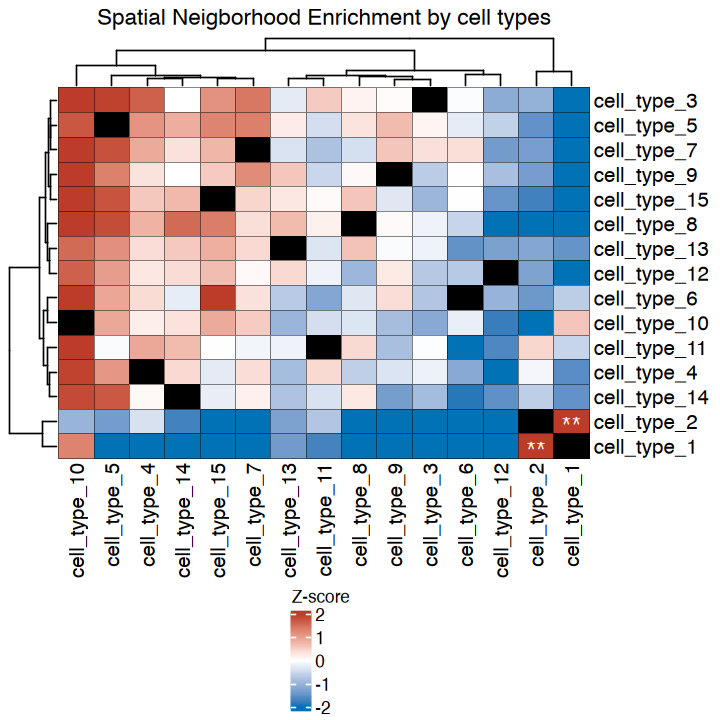

In [6]:
colnames(nhood_enrichment_res) = gsub("^Cluster","",colnames(nhood_enrichment_res))
rownames(nhood_enrichment_res) = gsub("^Cluster","",rownames(nhood_enrichment_res))
pval_mat <- 1 - pnorm(nhood_enrichment_res)

fdr_vec <- p.adjust(as.vector(pval_mat), method = "BH")
fdr_mat <- matrix(fdr_vec, nrow=nrow(nhood_enrichment_res), ncol=ncol(nhood_enrichment_res),
                  dimnames = dimnames(nhood_enrichment_res))

sig_mat <- ifelse(fdr_mat < 0.05, "**", ifelse(fdr_mat > 0.05 & fdr_mat < 0.1, "*", ""))

common_names <- intersect(rownames(nhood_enrichment_res), colnames(nhood_enrichment_res))
for (nm in common_names) {
  nhood_enrichment_res[nm, nm] <- NA
  sig_mat[nm, nm] <- ""
}

heatmap <- Heatmap(nhood_enrichment_res,
                   name = "Z-score",
                   col = colorRamp2(c(-2, 0, 2), c("#0072B5FF", "white", "#BC3C29FF")), 
                   show_row_names = TRUE, 
                   show_column_names = TRUE,  
                   cluster_rows = TRUE,  
                   cluster_columns = TRUE,  
                   #show_column_dend = FALSE,
                   #show_row_dend = FALSE,
                   row_title = "",  
                   column_title = "Spatial Neigborhood Enrichment by cell types",
                   rect_gp = gpar(col = "black", lwd = 0.3),
                   na_col = "black",          # make sure cell with same cell types in the row and column be NA
                   
                   cell_fun = function(j, i, x, y, width, height, fill) {
                     if(sig_mat[i, j] == "**") {
                       grid.text("**", 
                                 x = x,
                                 y = y - 0.2 * height,  
                                 gp = gpar(fontsize = 15, col = "white", fontface = "bold"))
                     }
                     if(sig_mat[i, j] == "*") {
                       grid.text("*", 
                                 x = x,
                                 y = y - 0.2 * height,  
                                 gp = gpar(fontsize = 15, col = "white", fontface = "bold"))
                     }
                   }
)

options(repr.plot.width=6, repr.plot.height=6)
draw(heatmap, 
     merge_legend = TRUE,
     heatmap_legend_side = "bottom", 
     annotation_legend_side = "bottom")

Run the same analysis with different distance parameters

In [7]:

set.seed(seed)
random_seeds <- sample(1000:9999, 100)

accuracy_df_all = data.frame()

library(foreach)
library(doParallel)
cl <- makeCluster(4)
registerDoParallel(cl)

accuracy_df <- foreach(
  distance_param = c(5,10,20,30,40,50,75,100),
  .combine = rbind, 
  .packages = c("ggplot2", "dplyr", "Seurat", "doParallel", "spatialCooccur")
) %:%
  foreach(
    test_type = c("circle"), 
    .combine = rbind
  ) %:%
  foreach(
    seed_ = random_seeds,
    .combine = rbind
  ) %dopar% {
    
    set.seed(seed_) 
    print(grep(seed_, random_seeds))
    
    df = generate_sim(close_ratio = close_ratio, 
                      n_types = n_types,  
                      max_loc = max_loc,
                      n_cells = n_cells,  
                      test_type = test_type,
                      distance_param = distance_param,  
                      seed=1234)
    
    nhood_enrichment_res <- nhood_enrichment(
      df,
      cluster_key = "cell_type", 
      neighbors.k = neighbors.k_, 
      connectivity_key = "nn", 
      transformation = TRUE,
      n_perms = n_perm, seed = seed_, n_jobs = 4
    )
    
    nhood_enrichment_res <- nhood_enrichment_res$zscore
    diag(nhood_enrichment_res) <- 0
    colnames(nhood_enrichment_res) <- gsub("^Cluster", "", colnames(nhood_enrichment_res))
    rownames(nhood_enrichment_res) <- gsub("^Cluster", "", rownames(nhood_enrichment_res))
    
    pval_mat <- 1 - pnorm(nhood_enrichment_res)
    fdr_vec <- p.adjust(as.vector(pval_mat), method = "BH")
    fdr_mat <- matrix(fdr_vec, nrow = nrow(nhood_enrichment_res), ncol = ncol(nhood_enrichment_res), dimnames = dimnames(nhood_enrichment_res))
    
    sig_mat <- ifelse(fdr_mat < 0.05, "**", ifelse(fdr_mat > 0.05 & fdr_mat < 0.1, "*", ""))
    
    result <- data.frame(
      test_type = test_type,
      seed = seed_,
      distance_param = distance_param,
      zscore = nhood_enrichment_res["cell_type_1", "cell_type_2"],
      zscore_false = nhood_enrichment_res["cell_type_3", "cell_type_4"]
    )
    
    return(result)
  }

stopCluster(cl)

accuracy_df <- as.data.frame(accuracy_df)
head(accuracy_df)
accuracy_df_all = rbind(accuracy_df_all,accuracy_df)

accuracy_df_all$n_types = n_types
accuracy_df_all$neighbors.k_ = neighbors.k_
accuracy_df_all$close_ratio = close_ratio
accuracy_df_all$n_perm = n_perm
accuracy_df_all$general_seed = seed
accuracy_df_all$max_loc = max_loc
accuracy_df_all$n_cells = n_cells


Loading required package: iterators

Loading required package: parallel



,test_type,seed,distance_param,zscore,zscore_false
,<chr>,<int>,<dbl>,<dbl>,<dbl>
1,circle,8451,5,7.002445,1.616697
2,circle,9015,5,7.208536,1.626845
3,circle,8161,5,7.041166,1.674403
4,circle,9085,5,6.918757,1.681377
5,circle,8268,5,6.947770,1.641342
6,circle,1622,5,6.885726,1.601686


`summarise()` has grouped output by 'zscore_type', 'test_type'. You can
override using the `.groups` argument.
Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
i Please use `linewidth` instead."


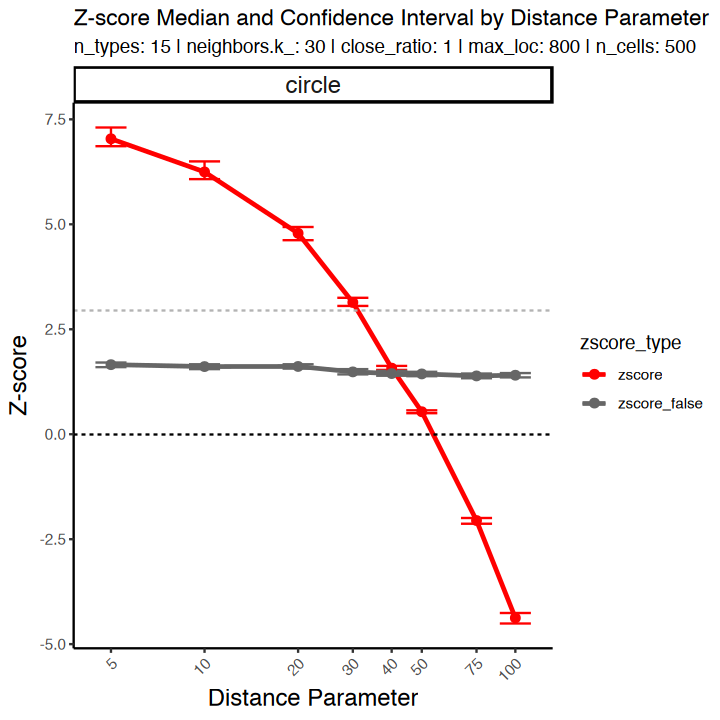

In [8]:

summary_df <- accuracy_df_all %>%
  dplyr::mutate(zscore_false = abs(zscore_false)) %>%
  tidyr::pivot_longer(cols = c(zscore, zscore_false), names_to = "zscore_type", values_to = "zscore") %>%
  dplyr::group_by(zscore_type, test_type, distance_param) %>%
  dplyr::summarise(
    median_zscore = median(zscore),
    lower_ci = quantile(zscore, 0.025),
    upper_ci = quantile(zscore, 0.975)
  ) %>%
  dplyr::ungroup()

options(repr.plot.width=6, repr.plot.height=6)
ggplot(summary_df, aes(x = distance_param, y = median_zscore, color = zscore_type)) +
  geom_line(size = 1) + 
  geom_errorbar(aes(ymin = lower_ci, ymax = upper_ci), width = 0.1) + 
  geom_point(size = 2) + 
  facet_wrap(test_type ~ .) + 
  labs(
    x = "Distance Parameter",
    y = "Z-score",
    title = "Z-score Median and Confidence Interval by Distance Parameter",
    subtitle = paste("n_types:", n_types, "| neighbors.k_:", neighbors.k_, "| close_ratio:", close_ratio, "| max_loc:", max_loc, "| n_cells:", n_cells)
  ) +
  scale_x_log10(breaks = c(unique(summary_df$distance_param))) + 
  scale_color_manual(values = c("zscore" = "red", "zscore_false" = "grey40")) +  
  geom_hline(yintercept = 0, linetype = "dashed") +  
  #geom_hline(yintercept = 1.96, linetype = "dashed", color = "grey70") +  
  geom_hline(yintercept = abs(qnorm((0.05/2/n_types),F)), linetype = "dashed", color = "grey70") + 
  theme_classic() +
  theme(
    strip.text = element_text(size = 14, face = "bold"), 
    axis.title = element_text(size = 14),
    axis.text.x = element_text(size = 9, angle = 45, hjust = 1)
  )

# Spatial co-localization score (sCLA, cell-cell level analysis)

Again we generate dummy data where two cell types (cell_type_1 and cell_type_2 in "cell_type" cik) are close to each other. Here we assume that cell_type_1 and cell_type_2 are close to each other (concentric cicle) by close_ratio.

In [9]:

seed=1234
close_ratio=1  # proportion of cell_type_1 and cell_type_2 that are close to each other
n_types=10  # Number of cell types
max_loc=800 # Maximum x and y coordinates in space
n_cells=500  # Number of total cells
test_type="circle" # "line", "circle", "distribute"
distance_param = 20  # distance between cell_type_1 and cell_type_2

df = generate_sim(close_ratio = close_ratio, 
                  n_types = n_types,  
                  max_loc = max_loc,
                  n_cells = n_cells,  
                  test_type = test_type,
                  distance_param = distance_param,  
                  seed=seed)
head(df) 
# x and y: coordinates
# cell_type: cell type

,x,y,cell_type
,<dbl>,<dbl>,<fct>
1,445.1298,397.7724,cell_type_1
2,437.2731,301.0822,cell_type_1
3,301.2229,365.6020,cell_type_1
4,335.8962,315.8329,cell_type_1
5,352.9081,515.0693,cell_type_1
6,322.6797,325.7101,cell_type_1


check the distribution of cell types in the space

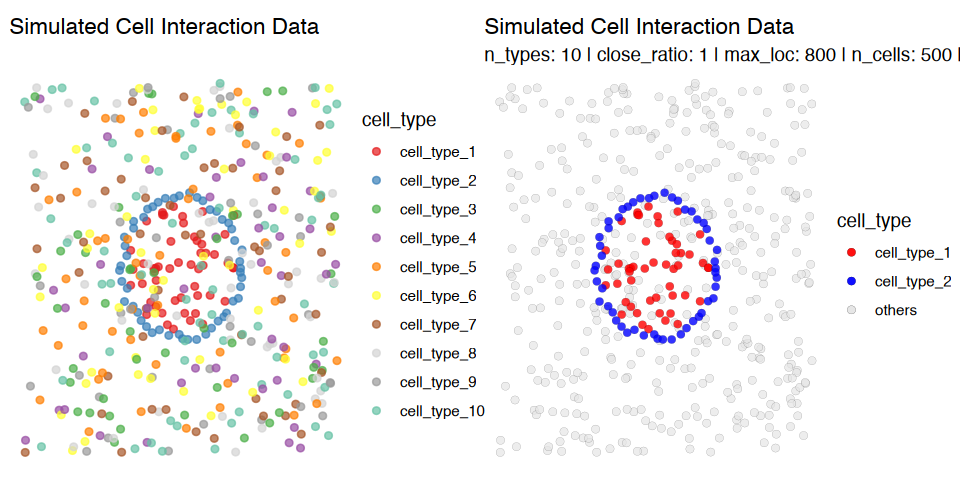

In [10]:

cluster_colors = manual_colors
names(cluster_colors) = paste0("cell_type_",1:n_types)

g1 = ggplot(df, aes(x = x, y = y, color = cell_type)) +
  geom_point(alpha = 0.7) +
  scale_color_manual(values = cluster_colors) +
  theme_void() +
  ggtitle("Simulated Cell Interaction Data")

g2 = ggplot(df %>% dplyr::mutate(cell_type = ifelse(cell_type %in% c("cell_type_1","cell_type_2"),as.character(cell_type),"others")), aes(x = x, y = y, fill = cell_type)) +
  geom_point(data = df %>% dplyr::mutate(cell_type = ifelse(cell_type %in% c("cell_type_1","cell_type_2"),as.character(cell_type),"others")) %>% dplyr::filter(cell_type %in% c("others")),
             alpha = 0.7, size = 2, shape = 21, stroke = 0.05, color = "black") +
  geom_point(data = df %>% dplyr::mutate(cell_type = ifelse(cell_type %in% c("cell_type_1","cell_type_2"),as.character(cell_type),"others")) %>% dplyr::filter(cell_type %in% c("cell_type_1","cell_type_2")),
             alpha = 0.8, size = 2, shape = 21, stroke = 0.05, color = "black") +
  labs(title = "Simulated Cell Interaction Data",
       subtitle = paste("n_types:", n_types, "| close_ratio:", close_ratio, "| max_loc:", max_loc, "| n_cells:", n_cells, "| distance_param:",distance_param)) +
  scale_color_manual(values = c("cell_type_1" = "red", 
                                "cell_type_2" = "blue",
                                "others" = "grey90")) +
  scale_fill_manual(values = c("cell_type_1" = "red", 
                               "cell_type_2" = "blue",
                               "others" = "grey90")) +
  theme_void()

options(repr.plot.width=8, repr.plot.height=4)
g1|g2

Run co-localization analysis

In [11]:
cluster_x <- "cell_type_1"
cluster_y <- "cell_type_2"

radius_ = 30 # Radius to search for neighbors (µm, cell_type_2) around anchor cells (cell_type_1)
neighbors.k_ = 30 # Number of neighbors to search

cooccur_local_df <- cooccur_local(
  df,
  cluster_x        = cluster_x,
  cluster_y        = cluster_y,
  connectivity_key = "nn",
  neighbors.k      = neighbors.k_, 
  radius           = radius_,
  maxnsteps        = 15
)
summary(cooccur_local_df)

 cooccur_local_cell_type_1_cell_type_2
 Min.   :0.0000                       
 1st Qu.:0.0000                       
 Median :0.0000                       
 Mean   :0.1020                       
 3rd Qu.:0.2141                       
 Max.   :0.3982                       

Check how the co-localization score is distributed in the space

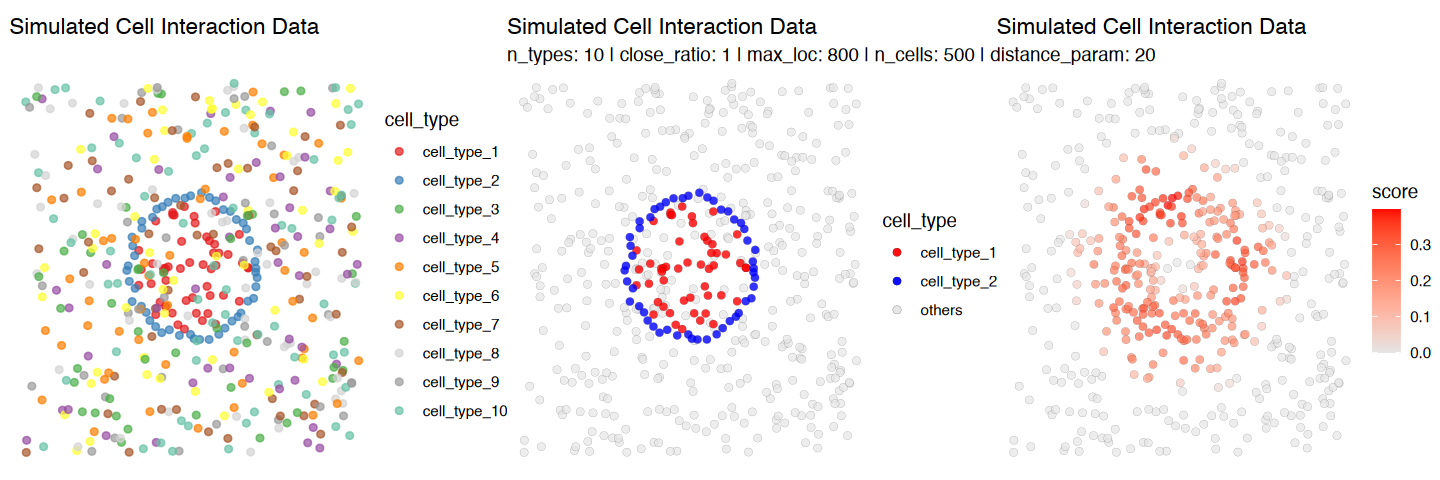

In [ ]:
g3 = ggplot() +
  geom_point(df %>%
               dplyr::mutate(score = cooccur_local_df$cooccur_local_cell_type_1_cell_type_2) %>%
               dplyr::filter(!(cell_type %in% c("cell_type_1","cell_type_2"))), 
             mapping = aes(x = x, y = y, fill = score),
             alpha = 0.7, size = 2, shape = 21, stroke = 0.05, color = "black") +
  geom_point(df %>%
               dplyr::mutate(score = cooccur_local_df$cooccur_local_cell_type_1_cell_type_2) %>%
               dplyr::filter(cell_type %in% c("cell_type_1","cell_type_2")), 
             mapping = aes(x = x, y = y, fill = score),
             alpha = 0.7, size = 2, shape = 21, stroke = 0.05, color = "black") +
  theme_void() +
  scale_fill_gradient(low = "grey90", high = "red") +
  ggtitle("Simulated Cell Interaction Data")

options(repr.plot.width=12, repr.plot.height=4)
g1 | g2 | g3

Check the relationship between the co-localization score and the distance between cell_type_1 and cell_type_2

Warning message in cor.test.default(na.omit(coords_df)$score, na.omit(coords_df)$dist_nearest, :
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(na.omit(coords_df)$score, na.omit(coords_df)$dist_nearest, :
"Cannot compute exact p-value with ties"
`geom_smooth()` using formula = 'y ~ x'
Warning message:
"Removed 400 rows containing non-finite values (`stat_smooth()`)."
Warning message:
"Removed 400 rows containing missing values (`geom_point()`)."


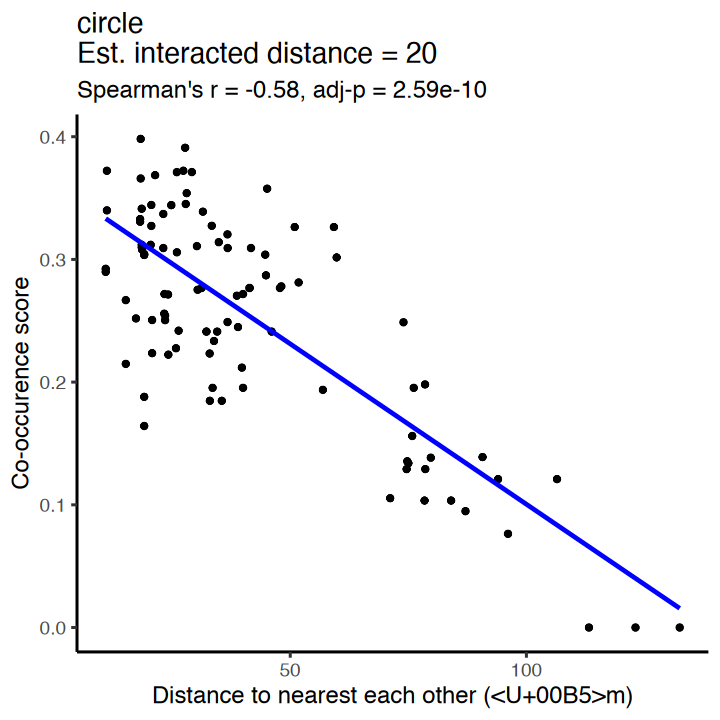

In [13]:

one_cells <- df %>% dplyr::filter(cell_type=="cell_type_1")
two_cells <- df %>% dplyr::filter(cell_type=="cell_type_2")

res <- RANN::nn2(data = one_cells[,1:2], query = two_cells[,1:2], k = 1)
dist_to_nearest <- res$nn.dists[, 1]
two_cells$dist_nearest <- dist_to_nearest

res <- RANN::nn2(data = two_cells[,1:2], query = one_cells[,1:2], k = 1)
dist_to_nearest <- res$nn.dists[, 1]
one_cells$dist_nearest <- dist_to_nearest

coords_df = dplyr::left_join(df %>%
                               dplyr::mutate(score = cooccur_local_df$cooccur_local_cell_type_1_cell_type_2), 
                             rbind(one_cells,two_cells), by = c("x","y","cell_type"))
coef = cor.test(na.omit(coords_df)$score,na.omit(coords_df)$dist_nearest,method = "spearman",use = "pairwise.complete.obs")$estimate
pval = cor.test(na.omit(coords_df)$score,na.omit(coords_df)$dist_nearest,method = "spearman",use = "pairwise.complete.obs")$p.value

options(repr.plot.width=6, repr.plot.height=6)
ggplot(data = coords_df, aes(x = dist_nearest, y = score)) +
  geom_point_rast() +
  geom_smooth(
    method = "lm", se = FALSE, color = "blue"
  ) +
  theme_classic(base_size = 14) +
  labs(
    x = "Distance to nearest each other (µm)",
    y = paste("Co-occurence score"),
    title = paste0(test_type,"\nEst. interacted distance = ", distance_param), 
    subtitle = paste0(
      "Spearman's r = ", round(coef, 2),
      ", adj-p = ", signif(pval, 3)
    )
  )



Check the ROC curve and AUC value to evaluate the performance of the co-localization score

Check the distribution of the co-localization score by cell type

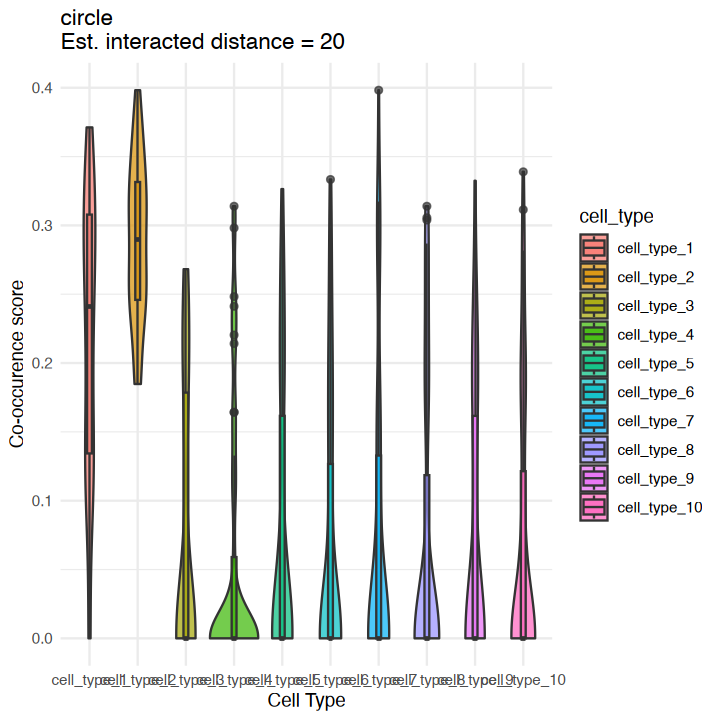

In [15]:
coords_df %>%
  ggplot(aes(x = cell_type, y = score, fill = cell_type)) +
  geom_violin(width = 1, alpha = 0.7) +
  geom_boxplot(width = 0.1, alpha = 0.7) +
  #geom_jitter(width = 0.1, alpha = 0.7) +
  theme_minimal() +
  labs(
    x = "Cell Type",
    y = "Co-occurence score",
    title = paste0(test_type,"\nEst. interacted distance = ", distance_param)
  )

In [16]:
sessionInfo()

R version 4.3.2 (2023-10-31)
Platform: aarch64-apple-darwin20 (64-bit)
Running under: macOS 15.3.2

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.3-arm64/Resources/lib/libRblas.0.dylib 
LAPACK: /Library/Frameworks/R.framework/Versions/4.3-arm64/Resources/lib/libRlapack.dylib;  LAPACK version 3.11.0

locale:
[1] C

time zone: America/Denver
tzcode source: internal

attached base packages:
[1] parallel  grid      stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] doParallel_1.0.17         iterators_1.0.14         
 [3] foreach_1.5.2             ggrastr_1.0.2            
 [5] ComplexHeatmap_2.18.0     circlize_0.4.15          
 [7] dplyr_1.1.4               magrittr_2.0.3           
 [9] ggplot2_3.4.4             patchwork_1.1.3          
[11] spatialCooccur_0.0.0.9000

loaded via a namespace (and not attached):
  [1] RColorBrewer_1.1-3     jsonlite_1.8.8         shape_1.4.6           
  [4] magick_2.8.2  